# Preprocessing
\
The raw data are point clouds generated by MLS (mobile LiDAR). The very first preprocessing step involves processing by the SLAM algorithm (more specifically, via the application provided by GeoSLAM), and unzip files.

Then, the next part consists in classifying ground points, generating a DTM, and extracting vegetation points in a slice parallel to DTM. This step is carried out using the opensource software Computree, and is detailed in the file computree_steps.xsct2 (it is ready to use, only the input files need to be selected and the output folder specified, parameters can also be viewed and modified).

Note: depending on the device you are using, it may be necessary to tile the point cloud before processing with Computree. In this case, make sure you convert to point format 7 and merge the output tile files before moving on. I recommend using CloudCompare for tiling and for converting .laz to .las.

*Output folder: 'computree_outputs'*

# Clustering
\
*Input folder: 'computree_outputs'*

In [ ]:
# Loading packages and modules
import os
import glob
from clustering import ClEngine, Cluster

las_files_path = 'computree_outputs' # location of preprocessed files
clustered_files_path = 'cluster_outputs' # location of clustered files

# Listing all .las files to cluster
las_files = glob.glob('computree_outputs/*.las')
print(las_files)

# Listing clustered files
clustered = glob.glob('cluster_outputs/*.las')
clustered_names = [os.path.splitext(os.path.basename(file))[0] for file in clustered]

In [ ]:
for file in las_files:
    
    # Checking if the file is not already clustered
    if os.path.splitext(os.path.basename(file))[0]+'_clusters' not in clustered_names:
        
        cl = ClEngine(file)
        
        # Cluster .las file points
        cl.DBSCAN_clustering(eps=0.05, min_samples=100) # distance parameters are in meters
        
        # Filter clusters given on a minimum number of points and minimum length. Note that filter based on
        # a minimum length take a long to process, set the min_dist param to "None" if you don't want to
        # use it.
        cl.filtering(nb_points=500, min_dist=None)
        
        # Draw a (very) basic representation of the clusters
        # cl.draw_clusters()
        
        # Save clustering results in new .las files (filename_clusters.las)
        cl.save_clusters()

*Output folder: 'cluster_outputs'*

# Cylinder fitting
\
A RANSAC cylinder fitting operation must be carried out. Here, it is carried out in CloudCompare, with the following parameters:  

    - Minimum support points per primitive: 500 or 1000 (depending on general point
    density of the .las file)
    - Use Least Squares fitting on found shapes
    - Attempt to simplify shapes
    - Set random color for each shape found
    - Looking for cylinder primitives  
    
    Parameters
    - Max distance to primitive: e = 0.1m
    - Sampling resolution: b = 0.02
    - Max normal deviation: a = 25.00°
    - Overlooking probability: 0.0001  
    
    Cylinder advanced parameters
    - Min radius: 0.03m
    - Max radius: 0.5m  
    
This step is also a visual validation step. Do not hesitate to change a few settings.

The point clouds of detected cylindrical shapes (not mesh !) must be exported in cloud ascii format (.txt), with headers as column titles. Make sure you save the multiple point clouds of the same study area in the same sub-folder.  

*Output folders: 'shapes_raw/sub-folders'*

# Image classification

## Image creation
\
First, we need to create images from the previously generated points clouds of cylindrical shapes. Graphs are generated from the points by colouring them according to their z coordinate, and are exported in .png format.

*Input folder: 'shapes_raw'*

In [ ]:
# Loading packages and modules
import os
import glob
import image_creation as imgcreate

# Path of folder with folders containing the files from which to create images
path_raw = 'shapes_raw'
img_path = 'shapes_img'

# Image sizing
image_size_inches = (4, 4) # in inches
dpi = 75

In [ ]:
# Browse all files and create images from each file
for folder in glob.glob(path_raw+'/*'):
    
    folder_name = os.path.splitext(os.path.basename(folder))[0]
    dest = img_path + '/' + folder_name
    
    imgcreate.image_generator(data_folder=folder, img_folder=dest, figsize=image_size_inches, dpi=dpi)

*Output folder: 'shapes_img'*

## NNCLR model building
\
The aim is not to spend our time manually classifying images, so we will be using a NNCLR model, adapted to a small labelled training set. The NNCLR model used here is based on the example of https://keras.io/examples/vision/nnclr/ (see link for more details).

*Input folder: 'NNCLR_data', containing images for training*

NNCLR_data
│
├── labelled
│   ├── deadwood
│   │   ├── image1.png
│   │   ├── image2.png
│   │   ├── ...
│   │
│   └── other
│       ├── image1.png
│       ├── image2.png
│       ├── ...
│
└── unlabelled
    └── unlabelled
        ├── image1.png
        ├── image2.png
        ├── ...

In [1]:
import os
import tensorflow as tf
import image_classification as imgclf

device = 'CPU:0' # device used to run tensorflow
model_path = 'NNCLR_data' # path with labelled and unlabelled images for training
save_path = model_path + '/finetuning_model'
batch_size = 32
num_epochs = 50 # max number of epochs, the model will stop automatically when val_p_loss has not increased for 5 epochs
image_size = (300, 300) # in pixels

Found 633 files belonging to 2 classes.
Using 507 files for training.
Found 633 files belonging to 2 classes.
Using 126 files for validation.
Found 1256 files belonging to 1 classes.
Building NNCLR model.
Epoch 1/50
31/31 [==============================] - 206s 7s/step - c_loss: 3.4628 - c_acc: 0.0436 - r_acc: 0.0084 - p_loss: 4.8319 - p_acc: 0.6732 - val_p_loss: 4.3815 - val_p_acc: 0.9167
Epoch 2/50
31/31 [==============================] - 231s 7s/step - c_loss: 3.4430 - c_acc: 0.0773 - r_acc: 0.0168 - p_loss: 3.6615 - p_acc: 0.9364 - val_p_loss: 8.2663 - val_p_acc: 0.8958
Epoch 3/50
31/31 [==============================] - 228s 7s/step - c_loss: 3.4220 - c_acc: 0.0706 - r_acc: 0.0161 - p_loss: 5.0028 - p_acc: 0.9184 - val_p_loss: 2.3954 - val_p_acc: 0.8438
Epoch 4/50
31/31 [==============================] - 218s 7s/step - c_loss: 3.4533 - c_acc: 0.0697 - r_acc: 0.0173 - p_loss: 9.0772 - p_acc: 0.8533 - val_p_loss: 13.6860 - val_p_acc: 0.9167
Epoch 5/50
31/31 [========================

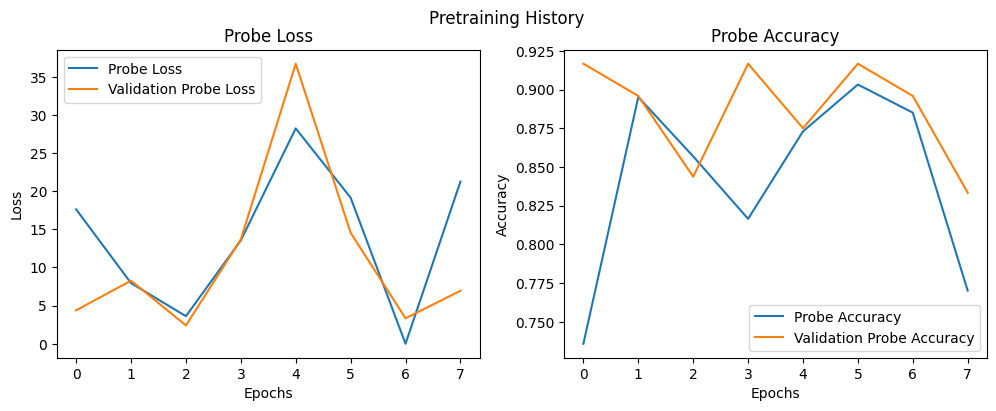

Epoch 1/50
31/31 [==============================] - 57s 2s/step - loss: 20.8907 - acc: 0.8952 - val_loss: 0.2569 - val_acc: 0.9271
Epoch 2/50
31/31 [==============================] - 58s 2s/step - loss: 0.2108 - acc: 0.9375 - val_loss: 0.4186 - val_acc: 0.9062
Epoch 3/50
31/31 [==============================] - 49s 2s/step - loss: 0.2070 - acc: 0.9355 - val_loss: 0.2381 - val_acc: 0.9167
Epoch 4/50
31/31 [==============================] - 52s 2s/step - loss: 0.2002 - acc: 0.9315 - val_loss: 0.2185 - val_acc: 0.9062
Epoch 5/50
31/31 [==============================] - 64s 2s/step - loss: 0.1918 - acc: 0.9395 - val_loss: 0.3125 - val_acc: 0.9062
Epoch 6/50
31/31 [==============================] - 51s 2s/step - loss: 0.1710 - acc: 0.9375 - val_loss: 0.3145 - val_acc: 0.9167
Epoch 7/50
31/31 [==============================] - 47s 1s/step - loss: 0.1786 - acc: 0.9294 - val_loss: 0.2141 - val_acc: 0.9167
Epoch 8/50
31/31 [==============================] - 46s 1s/step - loss: 0.1821 - acc: 0.9

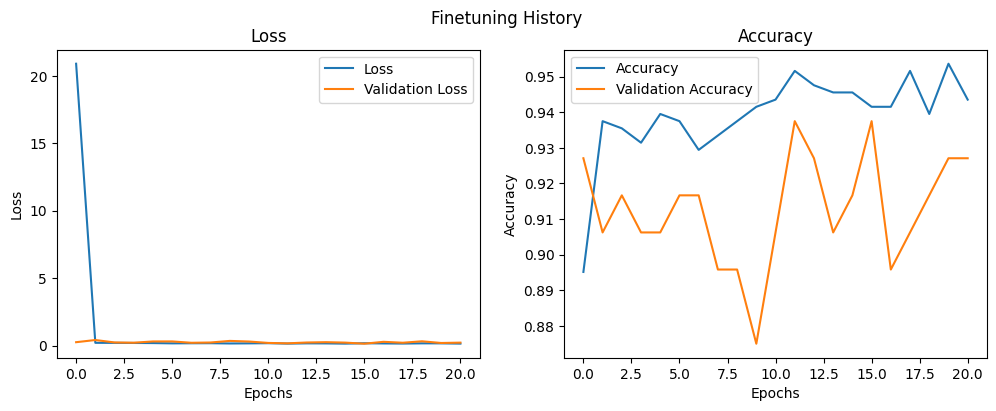

INFO:tensorflow:Assets written to: NNCLR_data/finetuning_model\assets


INFO:tensorflow:Assets written to: NNCLR_data/finetuning_model\assets


In [2]:
with tf.device(device):
    
    # Initialise model hyperparameters. For information:
    # input_shape = (image_size[0], image_size[1], 3)
    # AUTOTUNE = tf.data.AUTOTUNE
    # shuffle_buffer = 5000   
    # temperature = 0.1
    # queue_size = 10000
    # contrastive_augmenter = {
    #     "brightness": 0.5,
    #     "name": "contrastive_augmenter",
    #     "scale": (0.2, 1.0)}
    # classification_augmenter = {
    #     "brightness": 0.2,
    #     "name": "classification_augmenter",
    #     "scale": (0.5, 1.0)}
    # width = 128
    model = imgclf.Model(model_path, image_size, batch_size, num_epochs)
    
    # Prepare training and validation datasets
    model.prepare_dataset()
    
    # Pre-train NNCLR
    model.pretraining()
    
    # Evaluate the model
    model.finetuning(save_path=save_path)

## Identification of deadwood images and conversion into .las files

In [17]:
import os
import glob
import laspy
import numpy as np
import tensorflow as tf
import shape_processing as sp
import image_classification as imgclf

# Needed paths
model_path = 'NNCLR_data'
save_path = model_path + '/finetuning_model'
path_raw = 'shapes_raw'
path_img = 'shapes_img'
path_dw = 'deadwood'
spheres_file = 'preprocessing/spheres_coordinates.csv'

# Same as before
device = 'CPU:0'
batch_size = 32
num_epochs = 50
image_size = (300, 300)

# Get already classified file names
classified_files = glob.glob(path_dw+'/*.las')
classified_names = [os.path.splitext(os.path.basename(file))[0] for file in classified_files]

In [18]:
# Re-create model
model = imgclf.Model(model_path, image_size, batch_size, num_epochs)
model.load(save_path)

Model: "finetuning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_augmenter (S  (None, 300, 300, 3)      0         
 equential)                                                      
                                                                 
 encoder (Sequential)        (None, 128)               5181440   
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,182,730
Trainable params: 1,290
Non-trainable params: 5,181,440
_________________________________________________________________


In [19]:
# Browse folder for each study area
for folder in glob.glob(path_img+'/*'):
    
    folder_name = os.path.splitext(os.path.basename(folder))[0]
    
    #Check if classification is not already done
    if folder_name + '_deadwood' not in classified_names:
        
        print("Classifying " + folder_name + " shapes.")
        
        # Initialise counters...
        total = 0 # of total number of shapes
        dw = 0 # of identified deadwood shapes
        
        # Initialise new las file
        path_out = path_dw+'/'+folder_name+ '_deadwood.las'
        new_las = laspy.create(point_format=7, file_version="1.4")
        new_las.header.scales = np.array([1.e-05, 1.e-05, 1.e-05])
        new_las.write(path_out)
        
        # Browse all shapes of the study area
        for image in glob.glob(folder+'/*.png'):
            
            # Make a prediction with the model: each image classified as deadwood by the model, and
            # classified as "other" but with a score < treshold are kept in the final point cloud
            if model.prediction(image, treshold=0.8):
                
                image_name = os.path.splitext(os.path.basename(image))[0]
                shape_file = path_raw + '/' + folder_name + '/' + image_name + '.txt'
                shape = sp.shape_processing(shape_file)
                
                # Additional filters
                
                # Filtering by inclination to the vertical
                shape.inclination_filter(angle=40)
                
                # Filtering "flying" branches
                shape.flying_filter()
                
                # Filtering shapes outside the inventory plot
                shape.distance_from_centre(plot_name=folder_name, coord_file='preprocessing/spheres_coordinates.csv')
                
                if not shape.is_filtered():
                    
                    dw += 1
                    
                    # Create .las points
                    points = shape.las_points(header=new_las.header, label=dw)

                    # Append .las points to new file
                    with laspy.open(path_out, mode="a") as las_out:
                        las_out.append_points(points)                
            
            total += 1
        
        print(str(dw)+" shapes classified as deadwood out of "+str(total)+".\n")

Classifying 07_04 shapes.
12 shapes classified as deadwood out of 259.

Classifying BM03 shapes.
40 shapes classified as deadwood out of 518.

Classifying BM04 shapes.
40 shapes classified as deadwood out of 387.

Classifying BM06 shapes.
17 shapes classified as deadwood out of 351.

Classifying BM07 shapes.
116 shapes classified as deadwood out of 1061.

Classifying BM08 shapes.
25 shapes classified as deadwood out of 379.

